##Import necessary libraries

In [ ]:
import os
import glob
import math
import random
import copy
import json
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as nx_comm
import matplotlib.pyplot as plt
import seaborn as sns
import torch # Crucial for LPA implementation
from google.colab import drive
from abc import ABC, abstractmethod
from sklearn.metrics import roc_auc_score
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

# --- Plotting Aesthetics for Report Quality ---
# This makes all text larger and figures sharper (300 DPI for print quality)
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,           # High resolution for Colab view
    'savefig.dpi': 300,          # Print resolution
    'font.size': 12,             # Larger base font
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'legend.fontsize': 11,
    'lines.linewidth': 2
})
sns.set_style("whitegrid")      # Clean background for plots

##Load the dataset

In [ ]:
# Mount Drive if not already mounted
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Define the path to the folder
dataset_path = '/content/drive/My Drive/FB100'

def load_school_graph(school_name, path):
    """
    Loads a specific school graph from a GML file.
    Args:
        school_name (str): The name of the file without extension (e.g., 'Caltech36')
        path (str): The directory path
    Returns:
        G (networkx.Graph): The loaded graph
    """
    file_path = os.path.join(path, f"{school_name}.gml")

    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None

    try:
        # NetworkX reads GML files very easily
        # label='id' ensures nodes are indexed by their ID rather than a label string
        G = nx.read_gml(file_path, label='id')
        print(f"Successfully loaded {school_name}!")
        return G
    except Exception as e:
        print(f"Error loading graph: {e}")
        return None

Mounted at /content/drive


##Get only 3 concerned networks: Caltech, MIT, Johns Hopkins

In [ ]:
# Define the specific filenames for the 3 schools
target_files = {
    "Caltech": "Caltech36",
    "JohnsHopkins": "Johns Hopkins55",
    "MIT": "MIT8"
}

graphs = {}

print("--- Loading Target Networks ---")
for name, filename in target_files.items():
    G = load_school_graph(filename, dataset_path)

    if G:
      graphs[name] = G
      print(f"└── Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

--- Loading Target Networks ---
Successfully loaded Caltech36!
└── Nodes: 769, Edges: 16656
Successfully loaded Johns Hopkins55!
└── Nodes: 5180, Edges: 186586
Successfully loaded MIT8!
└── Nodes: 6440, Edges: 251252


##Plot the degree distribution for each network

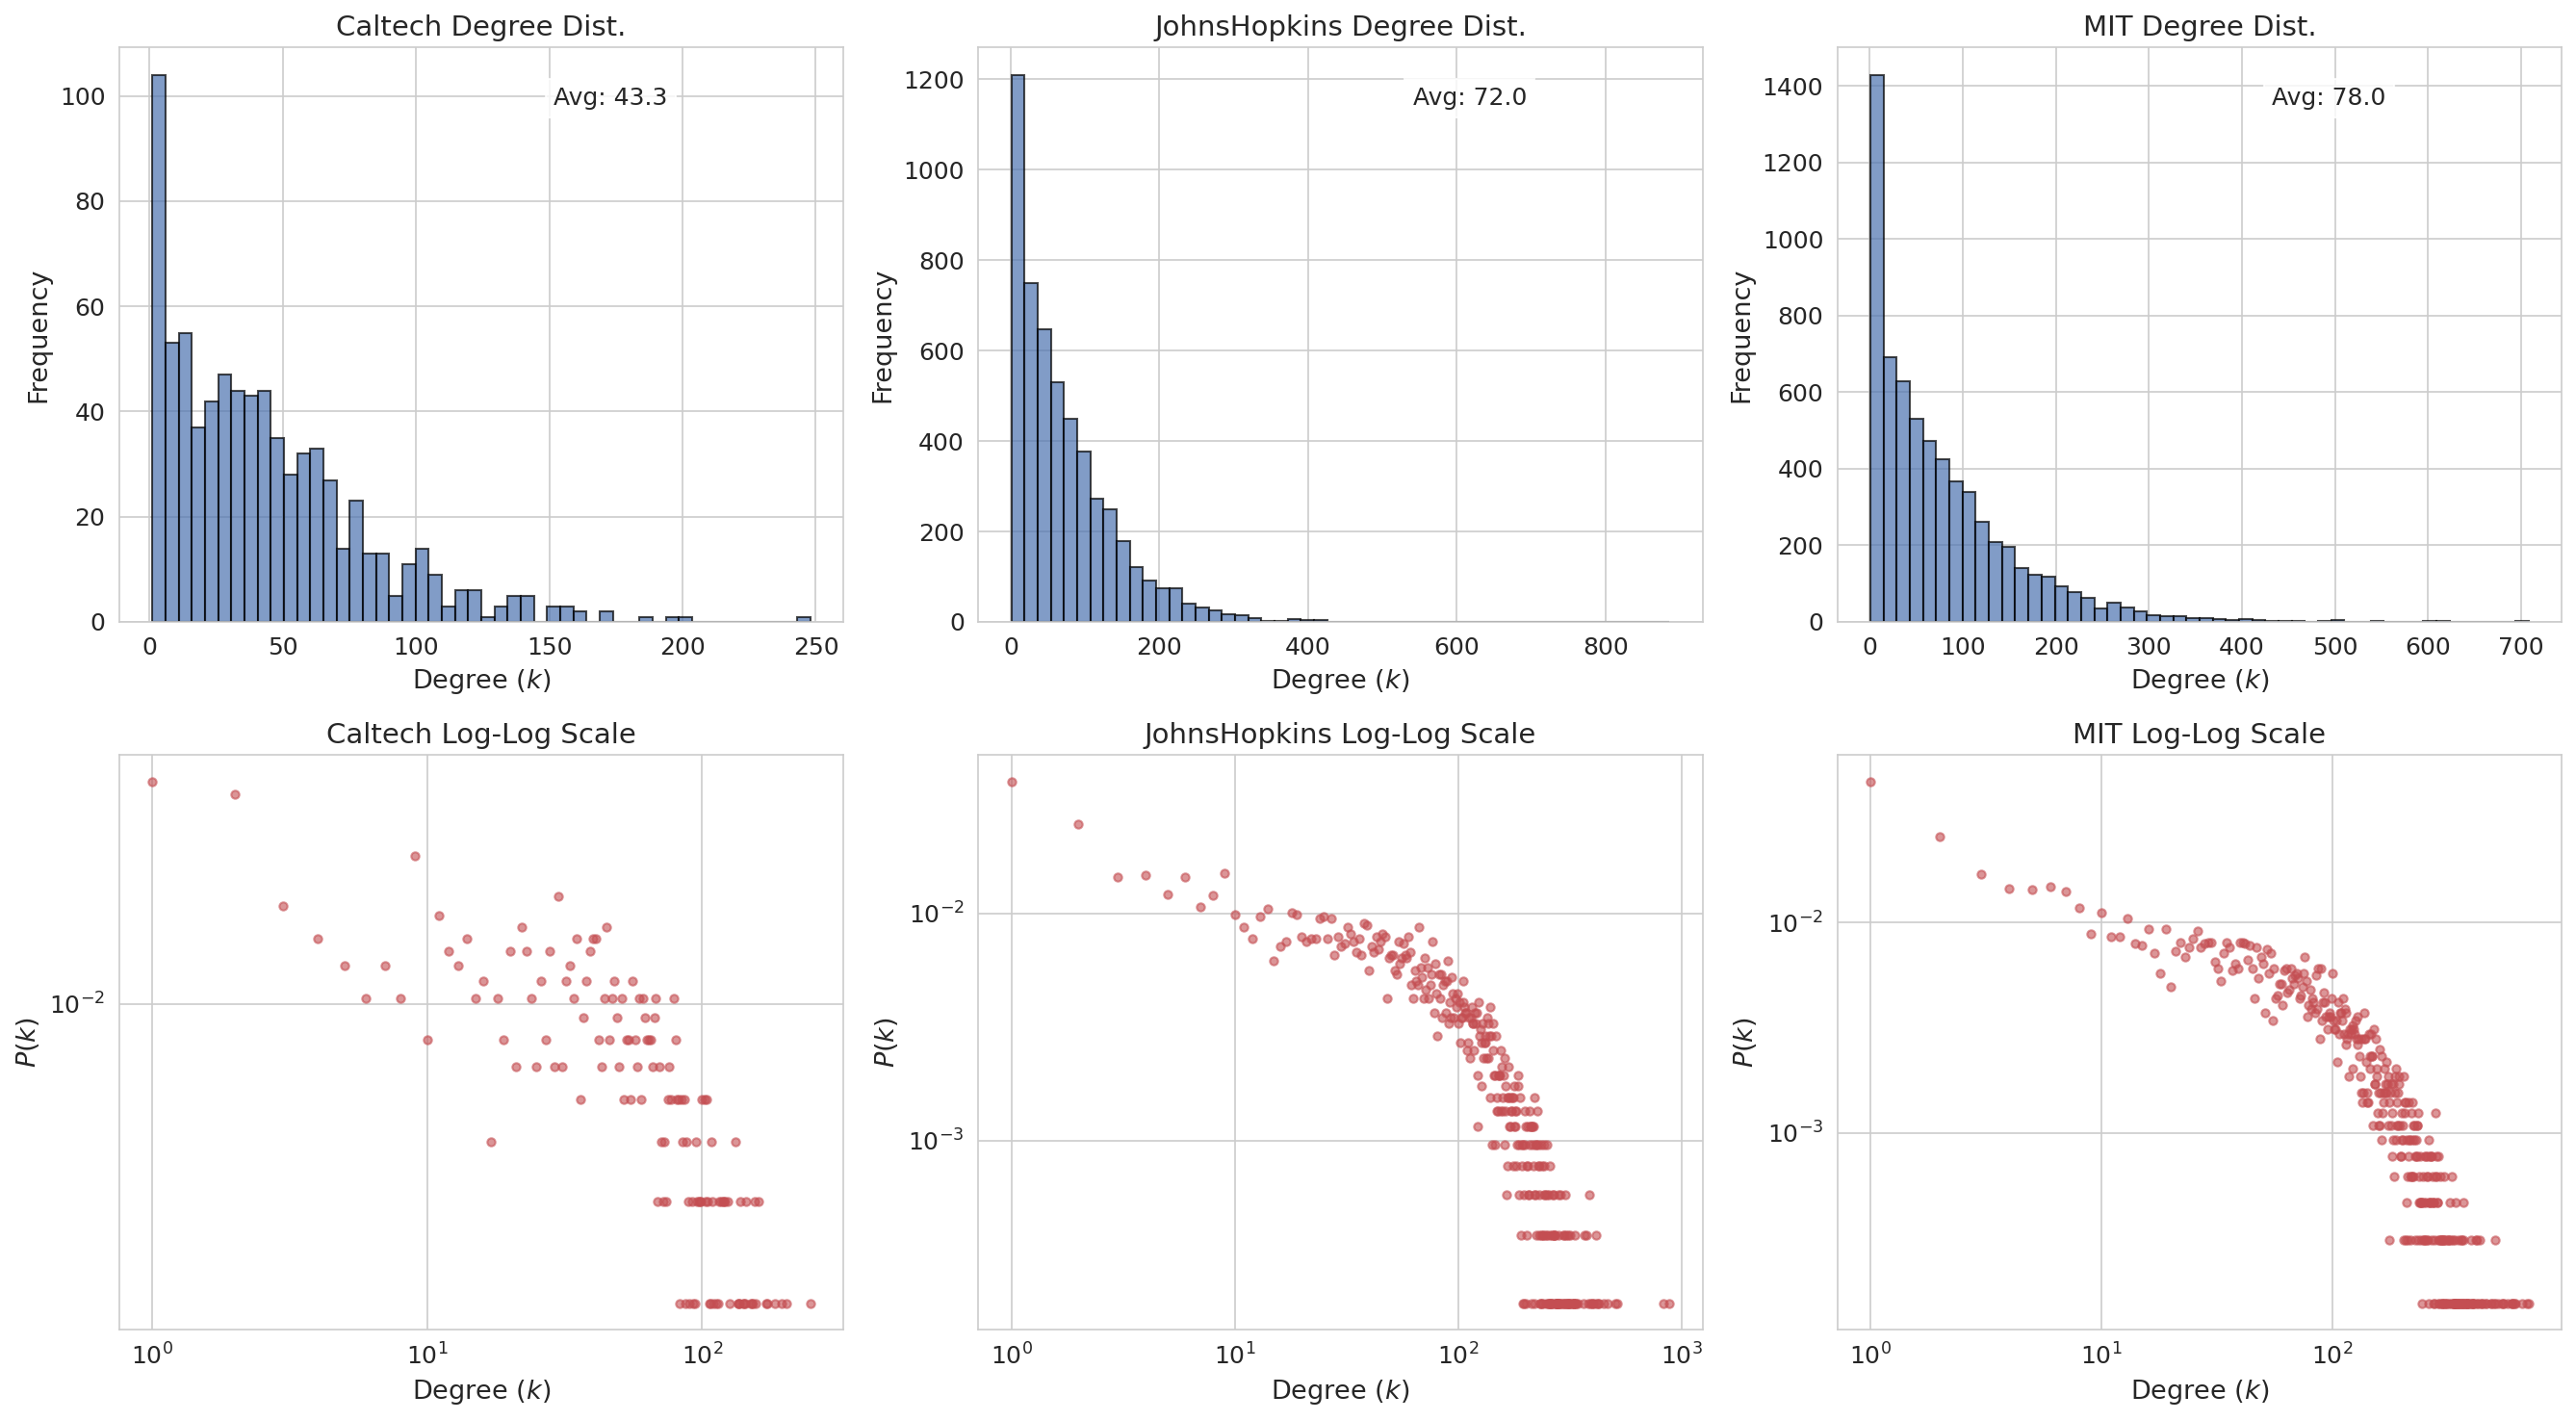

In [ ]:
def plot_degree_analysis(graph_dict):
    """
    Plots both the Histogram and Log-Log distribution side-by-side
    for better compact visualization in the report.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # 2 rows, 3 columns

    for i, (name, G) in enumerate(graph_dict.items()):
        degrees = [d for n, d in G.degree()]

        # Row 1: Histograms
        ax_hist = axes[0][i]
        ax_hist.hist(degrees, bins=50, color='#4c72b0', edgecolor='black', alpha=0.7)
        ax_hist.set_title(f"{name} Degree Dist.")
        ax_hist.set_xlabel("Degree ($k$)")
        ax_hist.set_ylabel("Frequency")
        # Add mean degree text
        avg_deg = np.mean(degrees)
        ax_hist.text(0.6, 0.9, f"Avg: {avg_deg:.1f}", transform=ax_hist.transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))

        # Row 2: Log-Log Plot
        ax_log = axes[1][i]
        degree_counts = {}
        for d in degrees:
            degree_counts[d] = degree_counts.get(d, 0) + 1
        sorted_deg = sorted(degree_counts.keys())
        probs = [degree_counts[k]/len(degrees) for k in sorted_deg]

        ax_log.loglog(sorted_deg, probs, '.', markersize=8, color='#c44e52', alpha=0.6)
        ax_log.set_title(f"{name} Log-Log Scale")
        ax_log.set_xlabel("Degree ($k$)")
        ax_log.set_ylabel("$P(k)$")

    plt.tight_layout()
    plt.show()

plot_degree_analysis(graphs)

##Compute global clustering coefficient and mean local clustering coefficient for each network

In [ ]:
def compute_clustering_metrics(graphs):
    results = []

    # Print Header
    print(f"{'School':<15} | {'Global (Transitivity)':<21} | {'Mean Local Clustering':<22}")
    print("-" * 80)

    for name, G in graphs.items():
        # 1. Global Clustering Coefficient (Transitivity)
        # Formula: 3 * (number of triangles) / (number of connected triples)
        global_clustering = nx.transitivity(G)

        # 2. Mean Local Clustering Coefficient
        # Average of the local clustering coefficients of all nodes
        mean_local_clustering = nx.average_clustering(G)

        # Store data for later use if needed
        results.append({
            "School": name,
            "Global_Clustering": global_clustering,
            "Mean_Local_Clustering": mean_local_clustering
        })

        # Print row
        print(f"{name:<15} | {global_clustering:.4f}                | {mean_local_clustering:.4f}")

    return pd.DataFrame(results)

# Run the function
df_clustering = compute_clustering_metrics(graphs)

School          | Global (Transitivity) | Mean Local Clustering 
--------------------------------------------------------------------------------
Caltech         | 0.2913                | 0.4093
JohnsHopkins    | 0.1932                | 0.2684
MIT             | 0.1803                | 0.2712


##Compute the edge density of each network

In [ ]:
def compute_edge_density(graphs):
    results = []

    print(f"{'School':<15} | {'Nodes':<8} | {'Edge Density':<15}")
    print("-" * 45)

    for name, G in graphs.items():
        density = nx.density(G)
        n = G.number_of_nodes()

        results.append({'School': name, 'Nodes': n, 'Density': density})

        print(f"{name:<15} | {n:<8} | {density:.6f}")

    return pd.DataFrame(results)

# Run the function
df_density = compute_edge_density(graphs)

School          | Nodes    | Edge Density   
---------------------------------------------
Caltech         | 769      | 0.056404
JohnsHopkins    | 5180     | 0.013910
MIT             | 6440     | 0.012118


##Plot degree versus local clustering coefficient

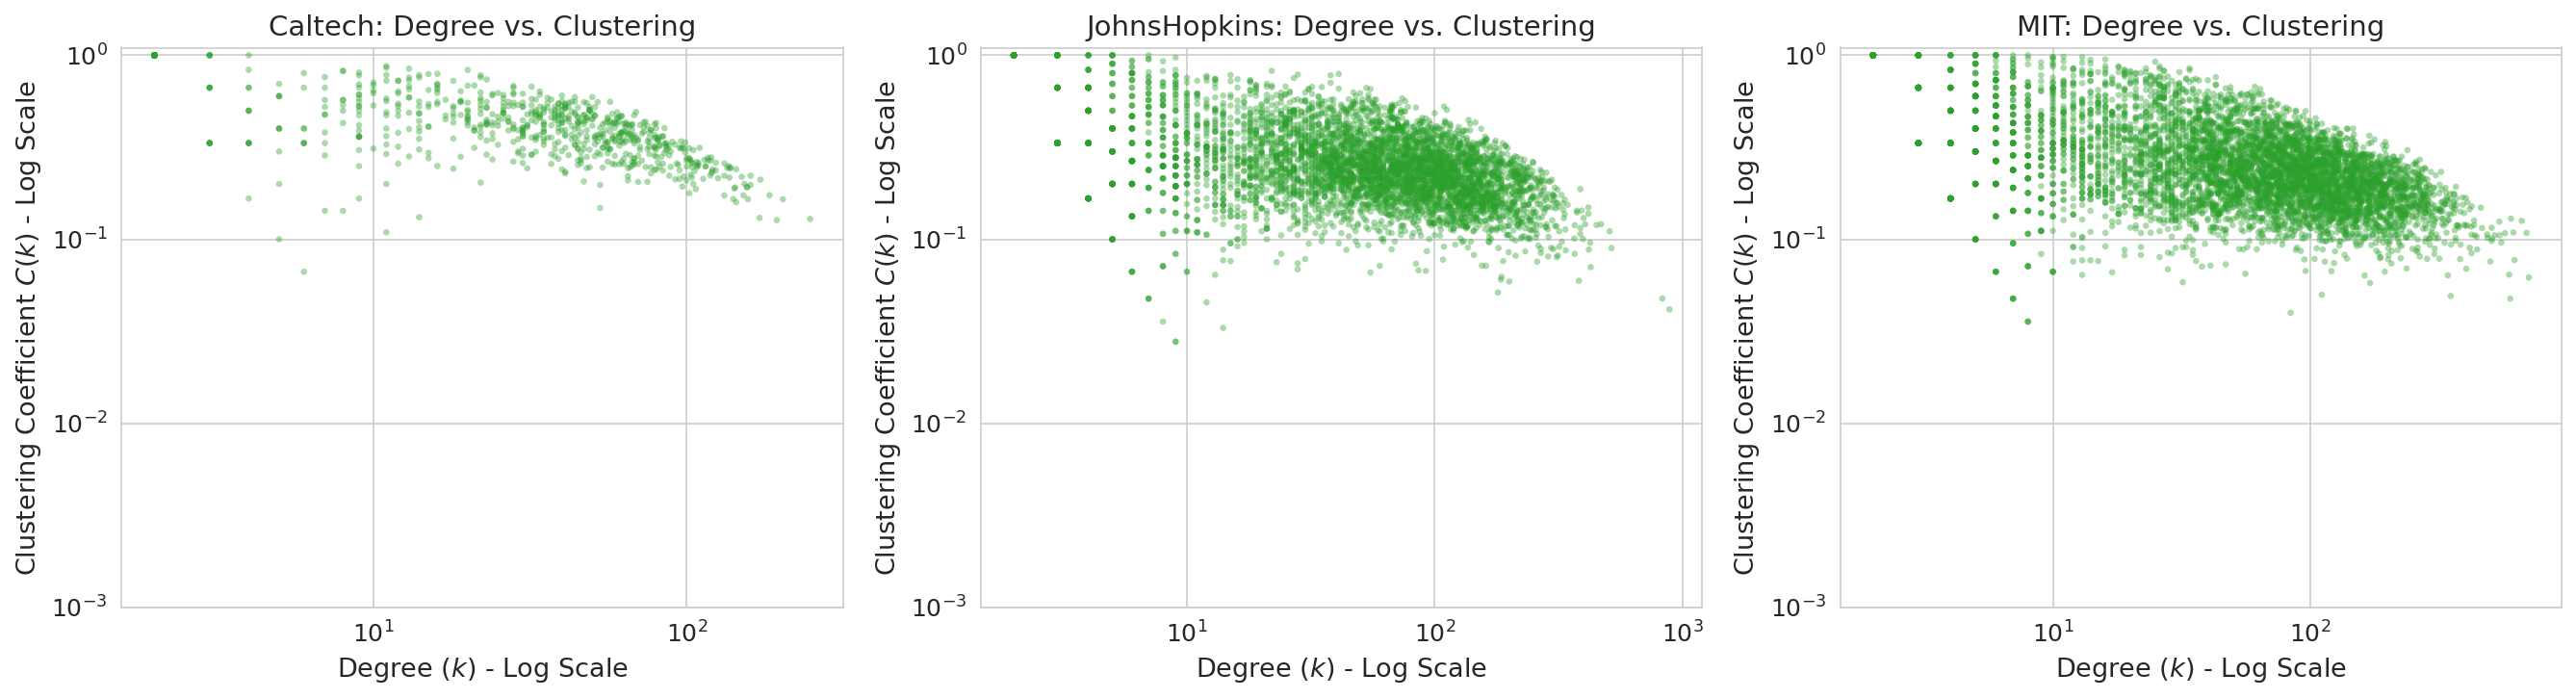

In [ ]:
def plot_degree_vs_clustering(graphs):
    # Create a subplot for each school (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, (name, G) in enumerate(graphs.items()):
        ax = axes[i]

        # 1. Calculate Degree and Clustering for every node
        # nx.clustering returns a dictionary {node_id: clustering_coeff}
        clustering_coeffs = nx.clustering(G)
        degree_dict = dict(G.degree())

        # 2. Align the data into X and Y lists
        # We iterate through nodes to ensure x[0] corresponds to y[0]
        x_degrees = []
        y_clustering = []

        for node in G.nodes():
            deg = degree_dict[node]
            clust = clustering_coeffs[node]

            # Optional: Filter out degree 0 or 1 to avoid log(0) issues or uninteresting points
            if deg > 1:
                x_degrees.append(deg)
                y_clustering.append(clust)

        # 3. Plot Scatter
        # alpha is transparency (helps visualize density where points overlap)
        ax.scatter(x_degrees, y_clustering, s=10, alpha=0.4, color='#2ca02c', edgecolors='none')

        # 4. Set Log-Log Scale (Standard for this analysis)
        ax.set_xscale('log')
        ax.set_yscale('log')

        # 5. Labels and Titles
        ax.set_title(f"{name}: Degree vs. Clustering")
        ax.set_xlabel("Degree ($k$) - Log Scale")
        ax.set_ylabel("Clustering Coefficient $C(k)$ - Log Scale")

        # Set limits slightly better for log view
        ax.set_ylim(0.001, 1.1)

    plt.tight_layout()
    plt.show()

# Run the function
plot_degree_vs_clustering(graphs)

##Compute the assortativity on all the schools

In [ ]:
def compute_five_attributes(path):
    files = glob.glob(os.path.join(path, "*.gml"))
    results = []

    print(f"Found {len(files)} networks. Calculating 5 attributes...")
    print("-" * 60)

    for i, file_path in enumerate(files):
        school_name = os.path.basename(file_path).replace(".gml", "")

        try:
            G = nx.read_gml(file_path, label='id')

            # Initialize row with school name
            row = {
                'School': school_name,
                'Nodes': G.number_of_nodes()
            }

            # 1. Vertex Degree Assortativity
            # (Do popular people tend to be friends with other popular people?)
            row['Degree'] = nx.degree_assortativity_coefficient(G)

            # 2. Attribute Assortativity
            # keys map the requested names to the internal GML variable names
            attr_map = {
                'Student/Faculty': 'student_fac',
                'Major': 'major_index',
                'Dorm': 'dorm',
                'Gender': 'gender'
            }

            for nice_name, gml_key in attr_map.items():
                try:
                    # Check if the first node has this attribute to avoid errors
                    first_node = list(G.nodes)[0]
                    if gml_key in G.nodes[first_node]:
                        val = nx.attribute_assortativity_coefficient(G, gml_key)
                        row[nice_name] = val
                    else:
                        row[nice_name] = np.nan # Attribute missing
                except:
                    row[nice_name] = np.nan

            results.append(row)

        except Exception as e:
            print(f"Error processing {school_name}: {e}")

        # Progress bar
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(files)}")

    return pd.DataFrame(results)

# Run the calculation
df_assort = compute_five_attributes(dataset_path)

# Show the first 5 rows to verify
print("\n--- Top 5 Rows ---")
print(df_assort.head())

Found 100 networks. Calculating 5 attributes...
------------------------------------------------------------
Processed 10/100
Processed 20/100
Processed 30/100
Processed 40/100
Processed 50/100
Processed 60/100
Processed 70/100
Processed 80/100
Processed 90/100
Processed 100/100

--- Top 5 Rows ---
    School  Nodes    Degree  Student/Faculty     Major      Dorm    Gender
0    USF51  13377  0.146424         0.110200  0.028574  0.141364 -0.066041
1  USFCA72   2682  0.091895         0.211121  0.066953  0.196693  0.021769
2     MIT8   6440  0.120051         0.315241  0.058067  0.178796  0.106376
3  UConn91  17212  0.088621         0.246317  0.046041  0.108436  0.011458
4    GWU54  12193  0.025287         0.358177  0.042821  0.156037  0.024769


/tmp/ipython-input-2385196932.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attribute', y='Assortativity Coefficient', data=df_melted,


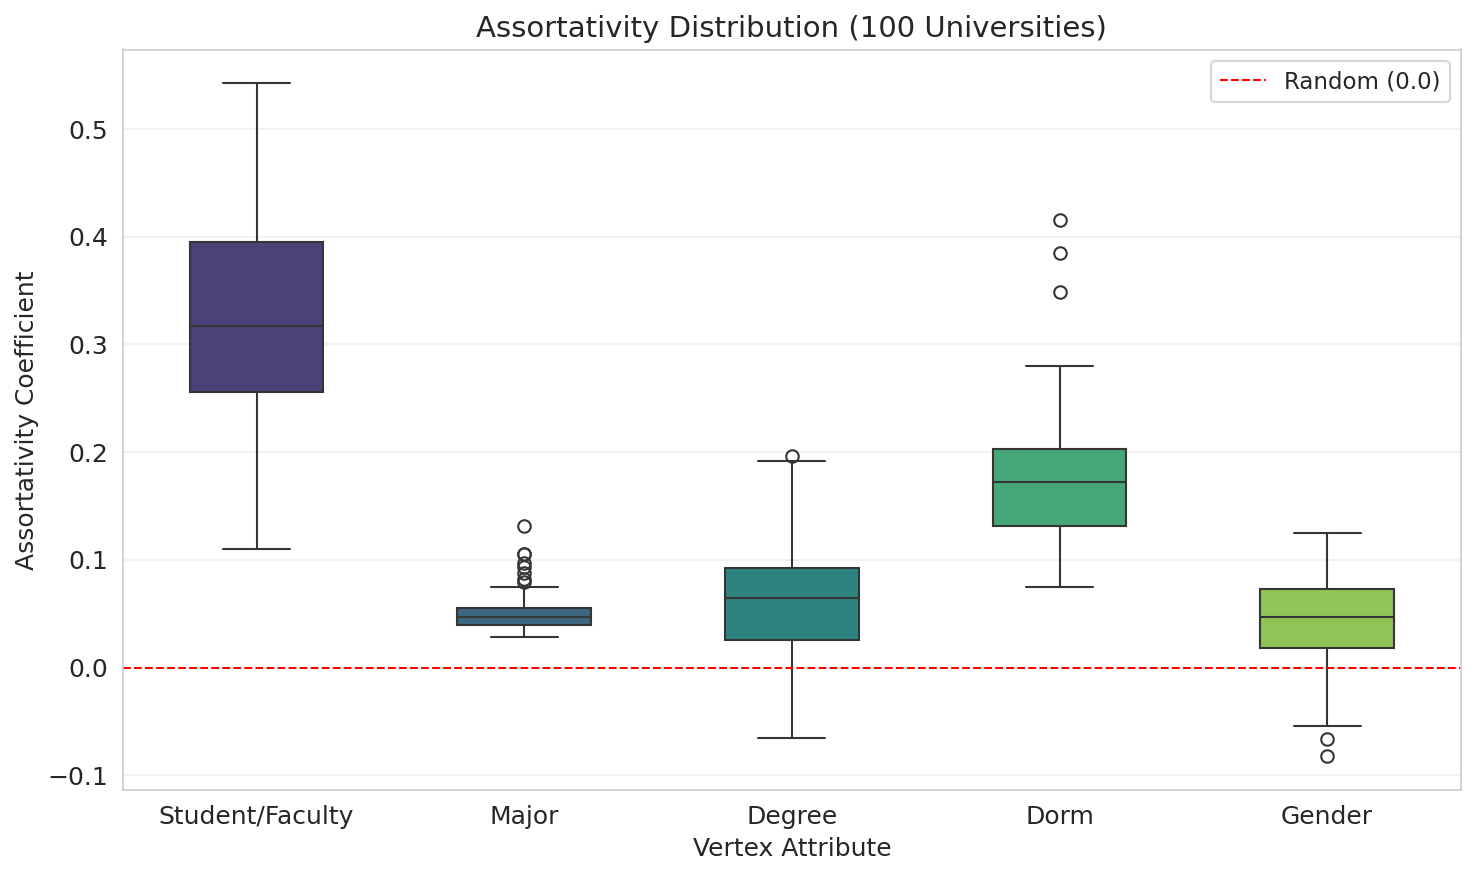

In [ ]:
def plot_five_attributes(df):
    plt.figure(figsize=(10, 6))

    # Reshape data for plotting
    # We strip 'School' and keep only the 5 numeric columns
    plot_cols = ['Student/Faculty', 'Major', 'Degree', 'Dorm', 'Gender']

    # Filter for columns that actually exist (just in case)
    existing_cols = [c for c in plot_cols if c in df.columns]

    df_melted = df.melt(id_vars=['School'], value_vars=existing_cols,
                        var_name='Attribute', value_name='Assortativity Coefficient')

    # Create Boxplot
    # 'width' controls the thickness of the boxes
    sns.boxplot(x='Attribute', y='Assortativity Coefficient', data=df_melted,
                palette="viridis", width=0.5)

    # Add reference line at 0 (Random mixing)
    plt.axhline(0, color='red', linestyle='--', linewidth=1, label="Random (0.0)")

    plt.title("Assortativity Distribution (100 Universities)", fontsize=14)
    plt.ylabel("Assortativity Coefficient", fontsize=12)
    plt.xlabel("Vertex Attribute", fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_five_attributes(df_assort)

##Generate log-linear scatter plots

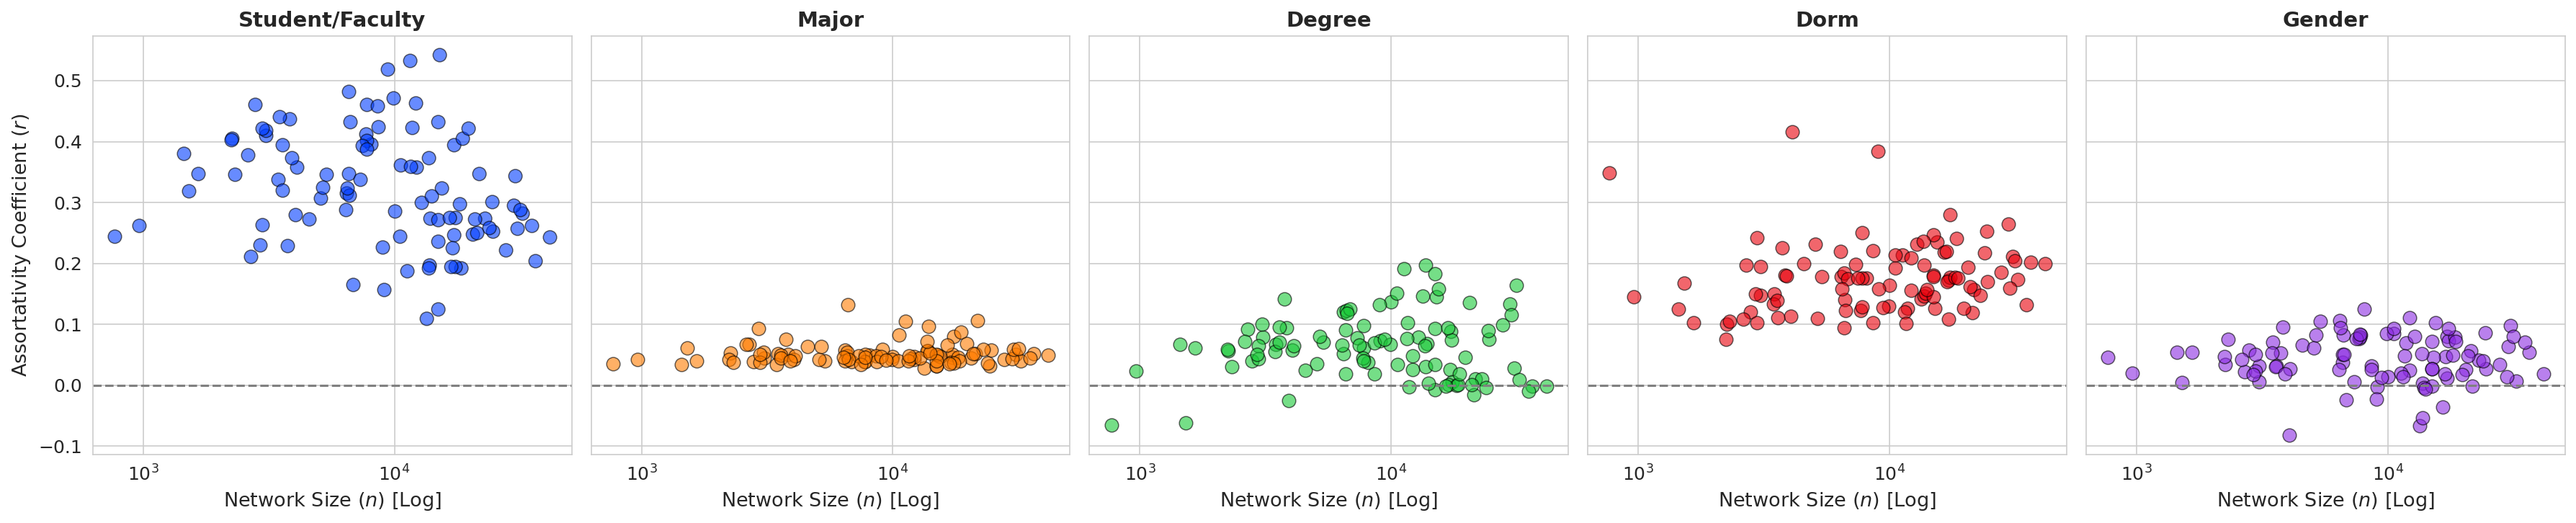

In [ ]:
def plot_assortativity_vs_size(df):
    attributes = ['Student/Faculty', 'Major', 'Degree', 'Dorm', 'Gender']
    fig, axes = plt.subplots(1, 5, figsize=(24, 5), sharey=True) # Wide layout

    colors = sns.color_palette("bright", n_colors=5)

    for i, attr in enumerate(attributes):
        ax = axes[i]
        if attr in df.columns:
            sns.scatterplot(data=df, x='Nodes', y=attr, ax=ax,
                            color=colors[i], s=80, edgecolor='black', alpha=0.6)

            ax.set_xscale('log')
            ax.set_title(attr, fontweight='bold')
            ax.set_xlabel("Network Size ($n$) [Log]")
            ax.axhline(0, color='gray', linestyle='--', linewidth=1.5) # Zero line

    axes[0].set_ylabel("Assortativity Coefficient ($r$)")
    plt.tight_layout()
    plt.show()

plot_assortativity_vs_size(df_assort)

##Plot the distribution of assortativity values

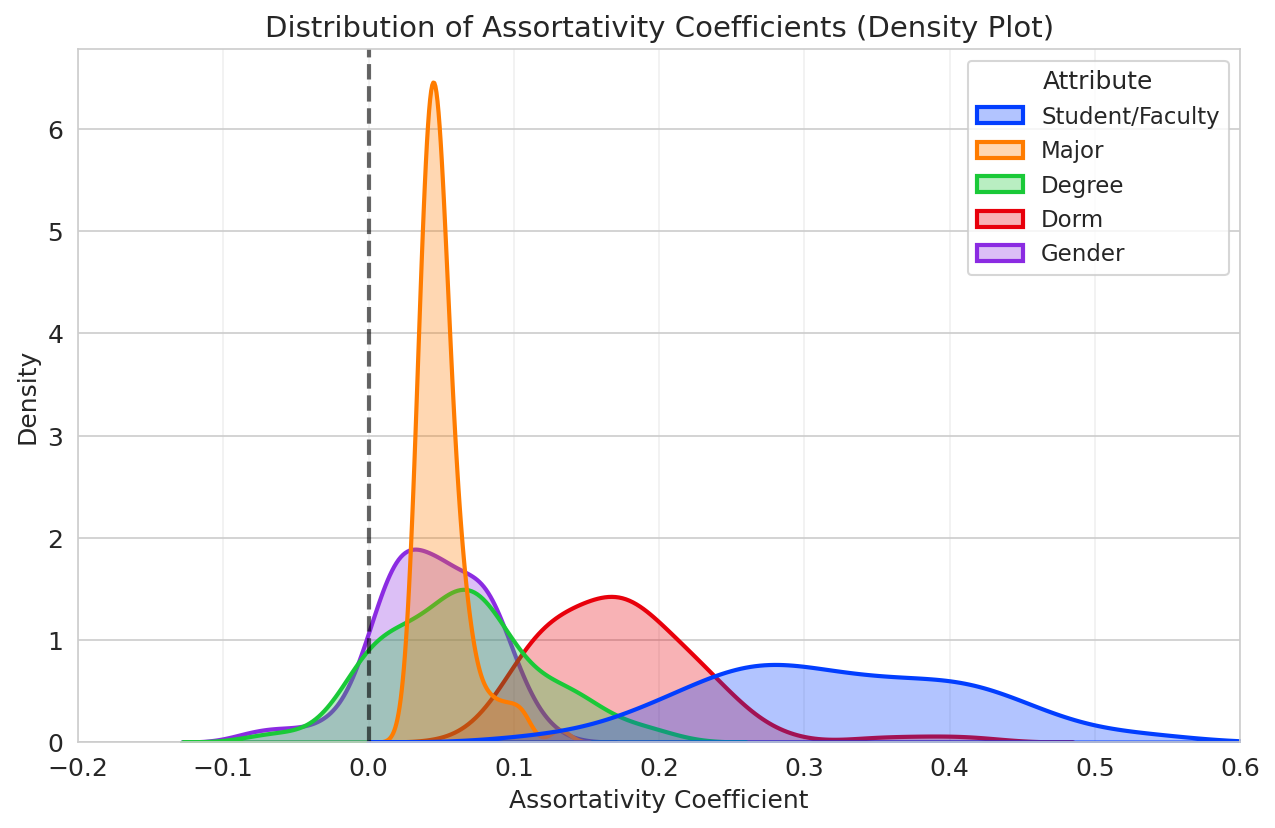

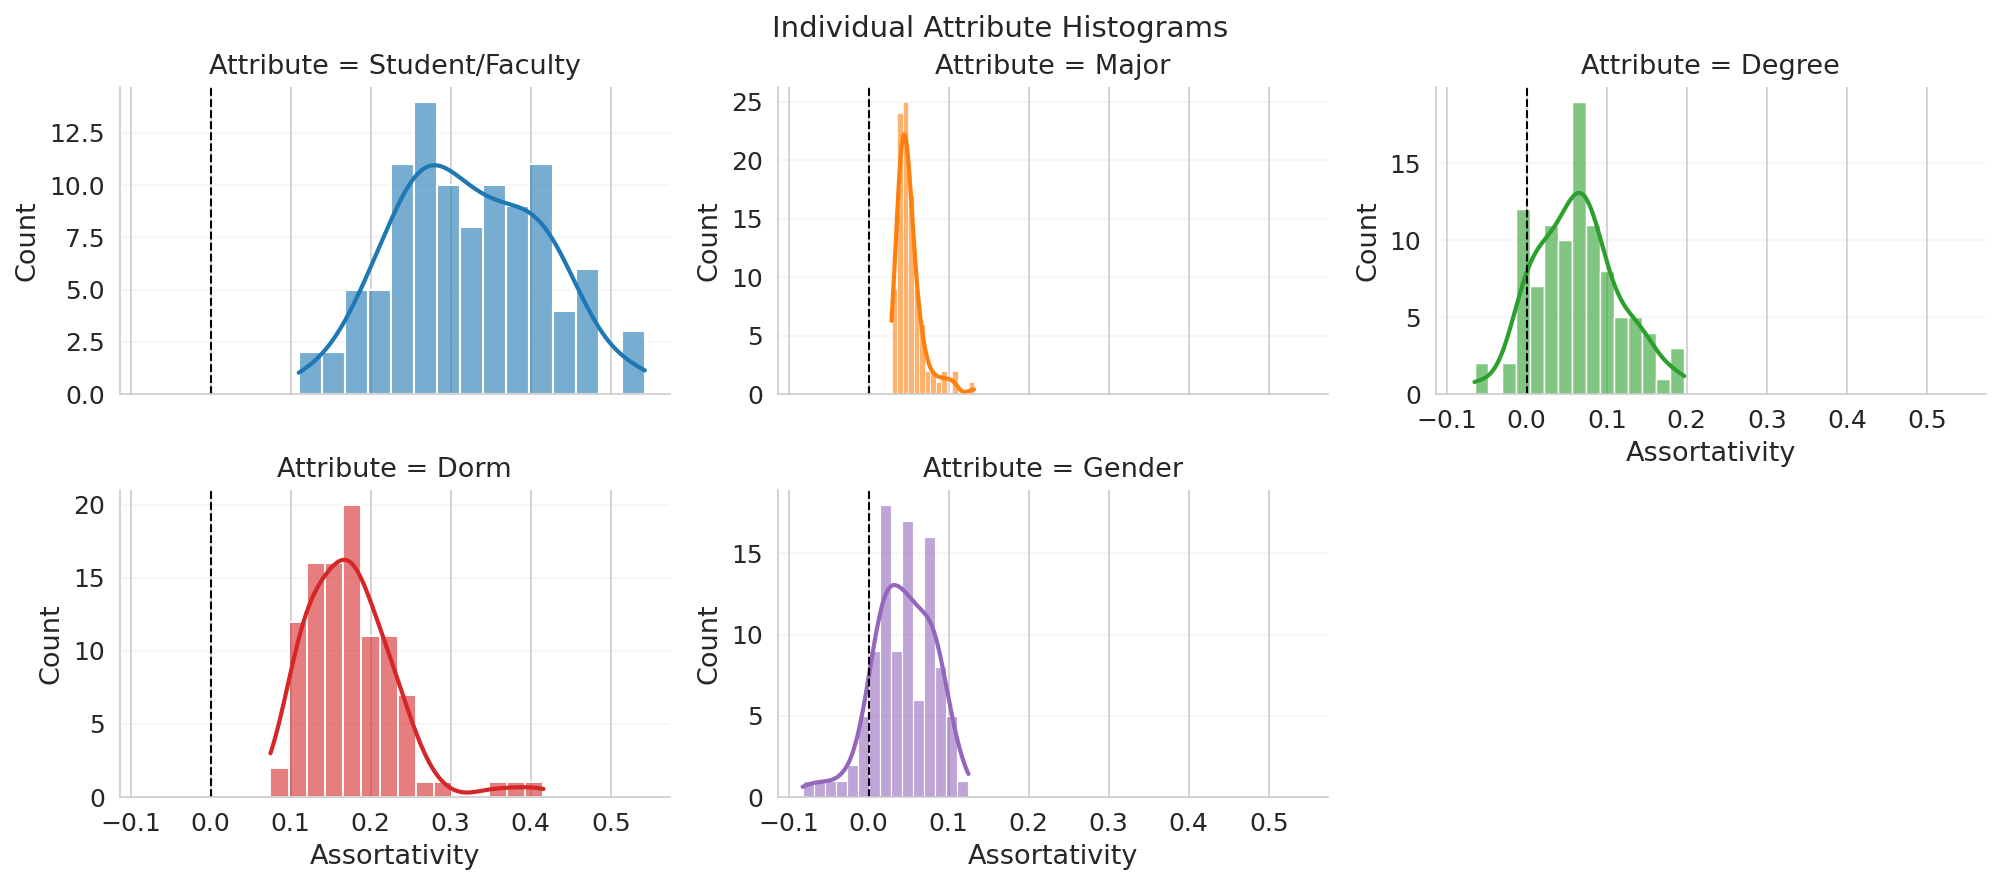

In [ ]:
def plot_assortativity_distributions(df):
    # 1. Prepare Data
    # List of columns to plot
    target_cols = ['Student/Faculty', 'Major', 'Degree', 'Dorm', 'Gender']

    # Filter only columns that exist in your dataframe
    valid_cols = [c for c in target_cols if c in df.columns]

    # "Melt" the dataframe into long format for Seaborn
    # This creates two columns: 'Attribute' (name) and 'Assortativity' (value)
    df_melted = df.melt(id_vars=['School'], value_vars=valid_cols,
                        var_name='Attribute', value_name='Assortativity')

    # --- Overlaid Density Plot (Smoother) ---
    plt.figure(figsize=(10, 6))

    # kdeplot draws the "mountain shapes"
    sns.kdeplot(data=df_melted, x='Assortativity', hue='Attribute',
                fill=True, alpha=0.3, linewidth=2, palette='bright')

    # Add a reference line at 0 (Random mixing)
    plt.axvline(0, color='black', linestyle='--', alpha=0.6, label='Random Mixing')

    plt.title('Distribution of Assortativity Coefficients (Density Plot)', fontsize=14)
    plt.xlabel('Assortativity Coefficient', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xlim(-0.2, 0.6) # Typical range for social networks
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    # --- Faceted Histograms (Detailed) ---
    # This creates a separate mini-chart for each attribute
    g = sns.FacetGrid(df_melted, col="Attribute", col_wrap=3,
                      hue="Attribute", sharex=True, sharey=False, height=3, aspect=1.5)

    g.map(sns.histplot, "Assortativity", kde=True, bins=15, alpha=0.6)

    # Add reference line to every subplot
    for ax in g.axes.flat:
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.grid(axis='y', alpha=0.2)

    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle('Individual Attribute Histograms', fontsize=14)
    plt.show()

# Run the plotting function
plot_assortativity_distributions(df_assort)

##Link prediction
Objective: Can we predict missing friendships based on the graph topology?

In [ ]:
class LinkPrediction(ABC):
    def __init__(self, graph):
        """
        Constructor
        Parameters
        ----------
        graph: Networkx graph
        """
        self.graph = graph
        self.N = len(graph)

    def neighbors(self, v):
        """
        Return the neighbors list of a node
        """
        # We optimize this by returning a set for faster intersections later
        return set(self.graph.neighbors(v))

    @abstractmethod
    def fit(self):
        raise NotImplementedError("Fit must be implemented")

    def predict(self, u, v):
        """
        Predict score for a specific edge (u, v)
        This is a helper method we will implement in subclasses
        """
        raise NotImplementedError("Predict must be implemented")

# --- 1. Common Neighbors ---
class CommonNeighbors(LinkPrediction):
    def __init__(self, graph):
        super(CommonNeighbors, self).__init__(graph)

    def fit(self):
        # Common Neighbors is a "lazy" learner, no training needed.
        pass

    def predict(self, u, v):
        # Formula: |N(u) ∩ N(v)|
        neighbors_u = self.neighbors(u)
        neighbors_v = self.neighbors(v)

        # Intersection of two sets
        return len(neighbors_u.intersection(neighbors_v))

# --- 2. Jaccard Coefficient ---
class Jaccard(LinkPrediction):
    def __init__(self, graph):
        super(Jaccard, self).__init__(graph)

    def fit(self):
        pass

    def predict(self, u, v):
        # Formula: |N(u) ∩ N(v)| / |N(u) U N(v)|
        neighbors_u = self.neighbors(u)
        neighbors_v = self.neighbors(v)

        intersection = len(neighbors_u.intersection(neighbors_v))
        union = len(neighbors_u.union(neighbors_v))

        if union == 0:
            return 0.0

        return intersection / union

# --- 3. Adamic/Adar ---
class AdamicAdar(LinkPrediction):
    def __init__(self, graph):
        super(AdamicAdar, self).__init__(graph)
        # We will store pre-computed log degrees here
        self.log_degrees = {}

    def fit(self):
        """
        Optimization: Pre-calculate 1/log(degree) for all nodes
        so we don't do math.log() millions of times during prediction.
        """
        for node in self.graph.nodes():
            degree = self.graph.degree(node)
            # Avoid division by zero (log(1) = 0)
            if degree > 1:
                self.log_degrees[node] = 1 / math.log(degree)
            else:
                self.log_degrees[node] = 0.0

    def predict(self, u, v):
        # Formula: sum( 1 / log(degree(z)) ) for all z in Common Neighbors
        neighbors_u = self.neighbors(u)
        neighbors_v = self.neighbors(v)

        common_neighbors = neighbors_u.intersection(neighbors_v)

        score = 0
        for z in common_neighbors:
            # Use our pre-calculated values
            score += self.log_degrees.get(z, 0.0)

        return score

In [ ]:
# Define the models we want to run
models = [
    CommonNeighbors,
    Jaccard,
    AdamicAdar
]

def evaluate_link_prediction(graph, model_class, pairs_to_score):
    """
    Runs a specific model on a specific graph for a list of pairs.
    """
    # 1. Instantiate the model
    model = model_class(graph)

    # 2. Fit (Pre-calculate stats if needed, e.g., for AdamicAdar)
    model.fit()

    # 3. Predict scores for the pairs
    scores = []
    for u, v in pairs_to_score:
        try:
            score = model.predict(u, v)
            scores.append(score)
        except Exception as e:
            # Handle cases where nodes might not be in the graph
            scores.append(0)

    return scores

##Helper function to remove edges

In [ ]:
def split_train_test(G, fraction):
    """
    Removes a fraction of edges from G to create a training graph.
    Returns:
        G_train: The graph with edges removed
        test_edges: The list of edges that were removed (Positives)
        non_edges: A list of non-edges (Negatives) of the same size for evaluation
    """
    # 1. Copy the graph so we don't destroy the original
    G_train = copy.deepcopy(G)

    # 2. Get all existing edges
    edges = list(G.edges())
    num_to_remove = int(len(edges) * fraction)

    # 3. Randomly select edges to remove
    # We use a fixed seed for reproducibility if needed, but random is fine here
    test_edges = random.sample(edges, num_to_remove)

    # 4. Remove them from the training graph
    G_train.remove_edges_from(test_edges)

    # 5. Sample Non-Edges (Negatives) for evaluation
    # We need to compare our "removed friends" against "random strangers"
    # Attempt to find non-edges roughly equal to num_to_remove
    # Note: simple rejection sampling is efficient for sparse graphs
    non_edges = set()
    while len(non_edges) < num_to_remove:
        u = random.choice(list(G.nodes()))
        v = random.choice(list(G.nodes()))

        # Conditions: u != v, no edge in original G, not already selected
        if u != v and not G.has_edge(u, v) and (u, v) not in non_edges and (v, u) not in non_edges:
            non_edges.add((u, v))

    return G_train, test_edges, list(non_edges)

##Evaluation loop

In [ ]:
# Define parameters
fractions = [0.05, 0.1, 0.15, 0.2]
target_school = "Caltech"
G_original = graphs[target_school]

# List of metric classes defined earlier
metrics = [CommonNeighbors, Jaccard, AdamicAdar]

results = []

print(f"--- Evaluating Link Prediction on {target_school} ---")

for f in fractions:
    print(f"\nProcessing fraction f={f}...")

    # 1. Split Data
    G_train, pos_edges, neg_edges = split_train_test(G_original, f)
    print(f"   Removed {len(pos_edges)} edges. Testing against {len(neg_edges)} non-edges.")

    # Combine positives and negatives into one list of pairs to score
    # We add a label '1' for removed edge, '0' for non-edge
    test_pairs = [(u, v, 1) for u, v in pos_edges] + [(u, v, 0) for u, v in neg_edges]

    # 2. Compute Metrics
    for MetricClass in metrics:
        metric_name = MetricClass.__name__

        # Instantiate the predictor on the TRAINING graph (partial view)
        predictor = MetricClass(G_train)
        predictor.fit()

        # Score all pairs
        # We collect: (u, v, Actual_Label, Predicted_Score)
        score_data = []
        for u, v, label in test_pairs:
            try:
                score = predictor.predict(u, v)
                score_data.append(score)
            except:
                score_data.append(0)

        # 3. Store Results for later analysis (e.g., AUC calculation)
        # For now, let's just store the raw lists or mean scores to verify it works
        # In a real report, we would calculate AUC-ROC here.
        results.append({
            'Fraction': f,
            'Metric': metric_name,
            'Labels': [x[2] for x in test_pairs],
            'Scores': score_data
        })
        print(f"   Computed {metric_name}")

print("\nEvaluation Complete.")

--- Evaluating Link Prediction on Caltech ---

Processing fraction f=0.05...
   Removed 832 edges. Testing against 832 non-edges.
   Computed CommonNeighbors
   Computed Jaccard
   Computed AdamicAdar

Processing fraction f=0.1...
   Removed 1665 edges. Testing against 1665 non-edges.
   Computed CommonNeighbors
   Computed Jaccard
   Computed AdamicAdar

Processing fraction f=0.15...
   Removed 2498 edges. Testing against 2498 non-edges.
   Computed CommonNeighbors
   Computed Jaccard
   Computed AdamicAdar

Processing fraction f=0.2...
   Removed 3331 edges. Testing against 3331 non-edges.
   Computed CommonNeighbors
   Computed Jaccard
   Computed AdamicAdar

Evaluation Complete.


##Compute the AUC

In [ ]:
summary_table = []

for res in results:
    # Calculate AUC
    auc = roc_auc_score(res['Labels'], res['Scores'])

    summary_table.append({
        'Fraction': res['Fraction'],
        'Metric': res['Metric'],
        'AUC': auc
    })

# Display as a clean dataframe
df_eval = pd.DataFrame(summary_table)

# Pivot table for easier reading
df_pivot = df_eval.pivot(index='Fraction', columns='Metric', values='AUC')
print(df_pivot)

Metric    AdamicAdar  CommonNeighbors   Jaccard
Fraction                                       
0.05        0.949622         0.944077  0.943710
0.10        0.944635         0.940666  0.936715
0.15        0.938783         0.934295  0.934280
0.20        0.935063         0.931026  0.927295


In [ ]:
def compute_top_k_metrics(results_list, k_values=[50, 100, 150, 200, 250, 300, 350, 400]):
    """
    Computes Precision@k and Recall@k for various k.

    Args:
        results_list: List of dicts containing 'Fraction', 'Metric', 'Labels', 'Scores'
        k_values: List of integers (the 'k' cutoffs)

    Returns:
        DataFrame containing the metrics for each config.
    """
    metrics_data = []

    for res in results:
        fraction = res['Fraction']
        metric_name = res['Metric']
        y_true = np.array(res['Labels'])
        y_scores = np.array(res['Scores'])

        # 1. Total True Positives (P) in the test set
        # (This is the denominator for Recall)
        total_positives = np.sum(y_true)

        # 2. Sort predictions by score (Descending)
        # argsort gives indices that sort the array, [::-1] reverses it for descending
        sorted_indices = np.argsort(y_scores)[::-1]
        sorted_labels = y_true[sorted_indices]

        # 3. Calculate metrics for each k
        for k in k_values:
            # Take top k
            top_k_labels = sorted_labels[:k]

            # TP@k: How many of these k are actually 1?
            tp_k = np.sum(top_k_labels)

            # Precision@k = TP / k
            precision_k = tp_k / k

            # Recall@k = TP / Total_Positives
            # Safety check to avoid division by zero if no edges were removed (unlikely)
            recall_k = tp_k / total_positives if total_positives > 0 else 0

            metrics_data.append({
                'Fraction': fraction,
                'Metric': metric_name,
                'k': k,
                'Top@k_Hits': tp_k,     # The raw count of correct hits
                'Precision': precision_k,
                'Recall': recall_k
            })

    return pd.DataFrame(metrics_data)

# --- Execute Analysis ---
# Define the k steps as requested (50 to 400)
k_steps = list(range(50, 450, 50))

# Compute metrics
df_k_metrics = compute_top_k_metrics(results, k_values=k_steps)

# Let's filter to look at just one fraction (e.g., 0.1) to see the table clearly
subset_view = df_k_metrics[df_k_metrics['Fraction'] == 0.1]
print("Results for Edge Removal Fraction = 0.1")
print(subset_view[['Metric', 'k', 'Precision', 'Recall']].to_string(index=False))

Results for Edge Removal Fraction = 0.1
         Metric   k  Precision   Recall
CommonNeighbors  50   1.000000 0.030030
CommonNeighbors 100   1.000000 0.060060
CommonNeighbors 150   1.000000 0.090090
CommonNeighbors 200   0.995000 0.119520
CommonNeighbors 250   0.992000 0.148949
CommonNeighbors 300   0.986667 0.177778
CommonNeighbors 350   0.988571 0.207808
CommonNeighbors 400   0.980000 0.235435
        Jaccard  50   0.980000 0.029429
        Jaccard 100   0.990000 0.059459
        Jaccard 150   0.986667 0.088889
        Jaccard 200   0.975000 0.117117
        Jaccard 250   0.976000 0.146547
        Jaccard 300   0.976667 0.175976
        Jaccard 350   0.974286 0.204805
        Jaccard 400   0.975000 0.234234
     AdamicAdar  50   1.000000 0.030030
     AdamicAdar 100   1.000000 0.060060
     AdamicAdar 150   1.000000 0.090090
     AdamicAdar 200   0.995000 0.119520
     AdamicAdar 250   0.996000 0.149550
     AdamicAdar 300   0.990000 0.178378
     AdamicAdar 350   0.988571 0.207808


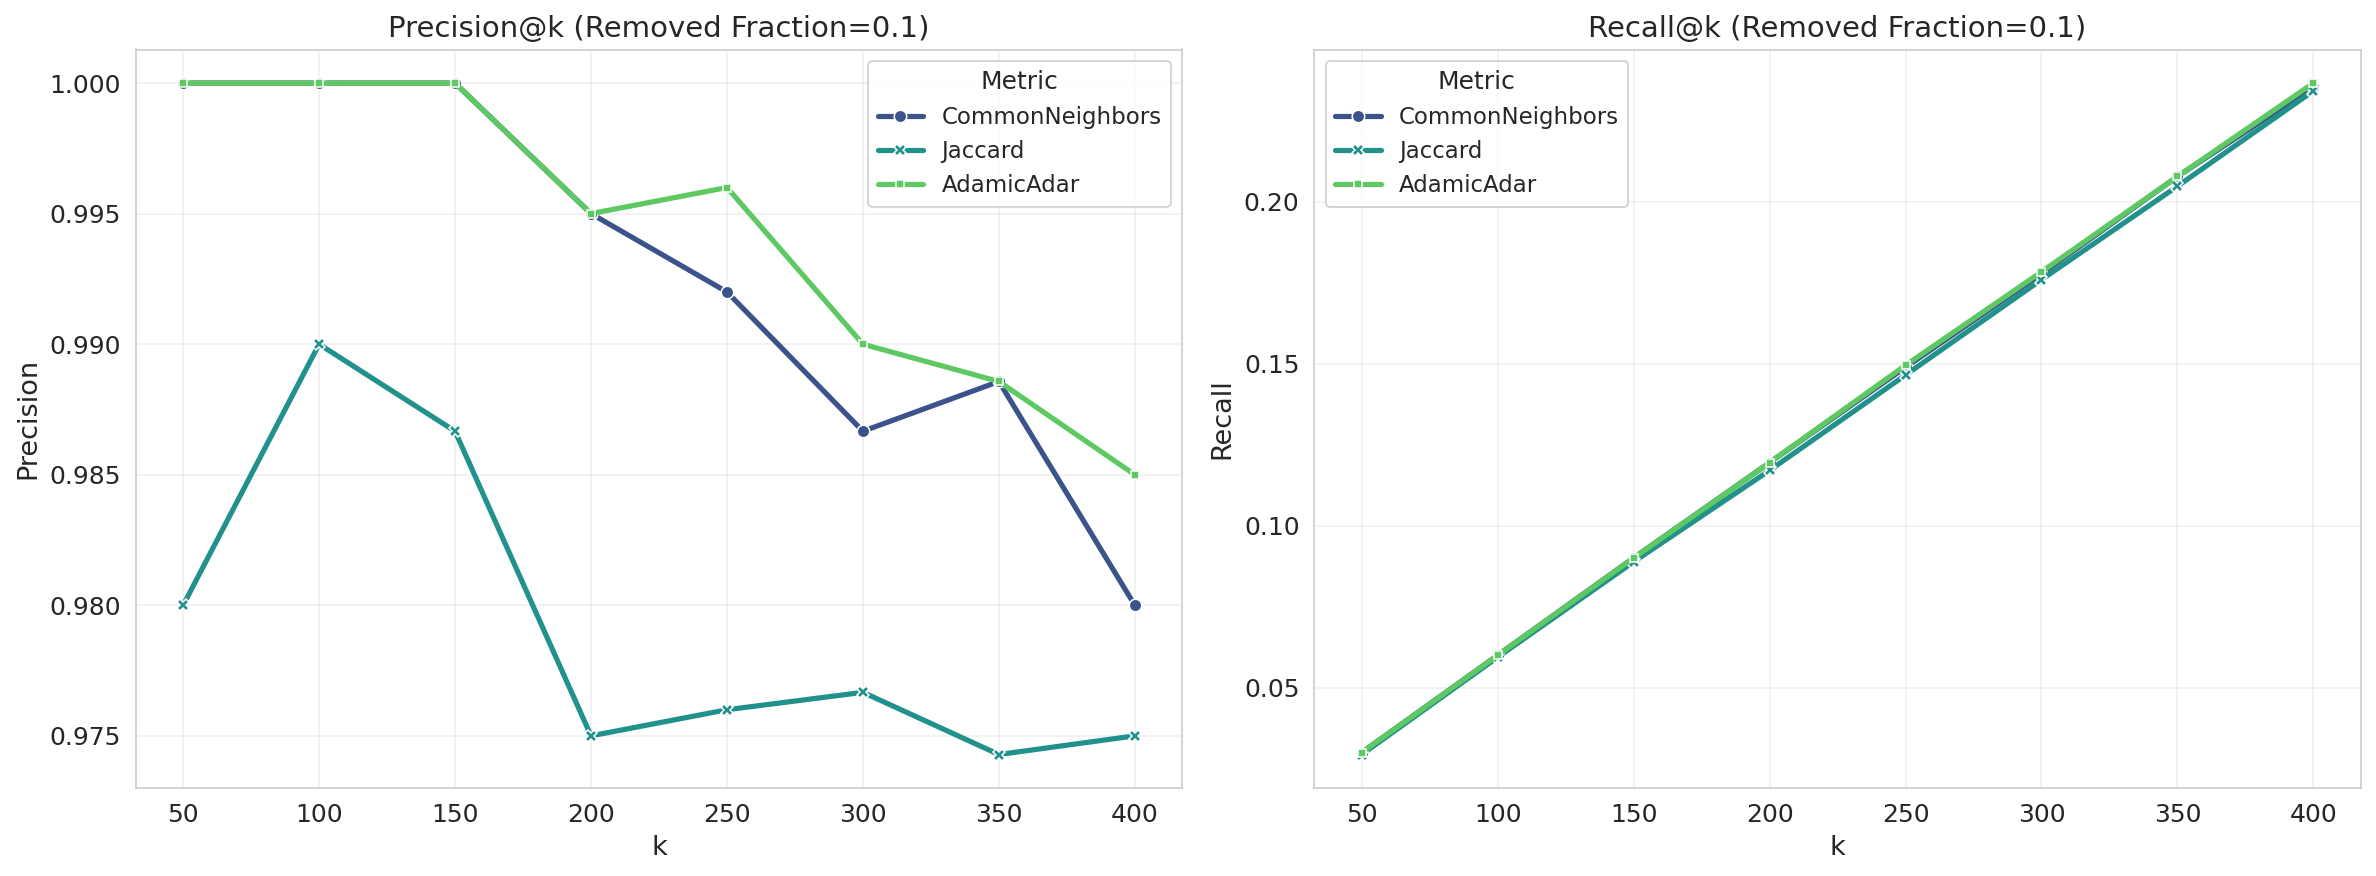

In [ ]:
def plot_precision_recall_comparison(df_metrics, specific_fraction=0.1):
    data = df_metrics[df_metrics['Fraction'] == specific_fraction]

    # Create one large figure with two panels
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Precision Plot
    sns.lineplot(data=data, x='k', y='Precision', hue='Metric',
                 style='Metric', markers=True, dashes=False,
                 linewidth=2.5, ax=ax1, palette="viridis")
    ax1.set_title(f'Precision@k (Removed Fraction={specific_fraction})')
    ax1.grid(True, alpha=0.3)

    # Recall Plot
    sns.lineplot(data=data, x='k', y='Recall', hue='Metric',
                 style='Metric', markers=True, dashes=False,
                 linewidth=2.5, ax=ax2, palette="viridis")
    ax2.set_title(f'Recall@k (Removed Fraction={specific_fraction})')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_precision_recall_comparison(df_k_metrics, specific_fraction=0.1)

##Compare 2 different graphs (schools)

In [ ]:
# --- Configuration ---
# We will compare Caltech (Small) vs. MIT (Large)
target_schools = ['Caltech', 'MIT']
fractions = [0.05, 0.1, 0.15, 0.2]  # We use 20% removal for the main comparison
k_values = [50, 100, 200, 400]

# --- Helper Function: The Full Pipeline per School ---
def evaluate_school_performance(school_name, G_original):
    school_results = []

    print(f"\nStarting Analysis for: {school_name} (Nodes: {len(G_original)})")

    for f in fractions:
        # 1. Split Data
        # (Using the split_train_test function defined in previous step)
        G_train, pos_edges, neg_edges = split_train_test(G_original, f)

        # Combine into a test set: (u, v, label)
        test_pairs = [(u, v, 1) for u, v in pos_edges] + [(u, v, 0) for u, v in neg_edges]

        # 2. Run Each Predictor
        for MetricClass in [CommonNeighbors, Jaccard, AdamicAdar]:
            metric_name = MetricClass.__name__

            # Init & Fit
            model = MetricClass(G_train)
            model.fit()

            # Predict
            scores = []
            labels = []
            for u, v, label in test_pairs:
                try:
                    s = model.predict(u, v)
                    scores.append(s)
                    labels.append(label)
                except:
                    scores.append(0)
                    labels.append(label)

            # 3. Compute Top-k Metrics immediately
            # Convert to numpy for easy sorting
            y_true = np.array(labels)
            y_scores = np.array(scores)

            # Sort descending
            sorted_indices = np.argsort(y_scores)[::-1]
            sorted_labels = y_true[sorted_indices]
            total_positives = np.sum(y_true)

            for k in k_values:
                top_k = sorted_labels[:k]
                tp = np.sum(top_k)

                precision = tp / k
                recall = tp / total_positives

                school_results.append({
                    'School': school_name,
                    'Metric': metric_name,
                    'Fraction': f,
                    'k': k,
                    'Precision': precision,
                    'Recall': recall,
                    'AUC': roc_auc_score(labels, scores) # Good for global check
                })

    return pd.DataFrame(school_results)

# --- Main Execution Loop ---
all_results = pd.DataFrame()

for school in target_schools:
    if school in graphs:
        df_school = evaluate_school_performance(school, graphs[school])
        all_results = pd.concat([all_results, df_school], ignore_index=True)
    else:
        print(f"Warning: {school} not found in 'graphs' dictionary.")

# --- Display Comparative Table (Focus on k=100) ---
print("\n" + "="*60)
print("FINAL COMPARISON (k=400, Fraction=0.2)")
print("="*60)

final_view = all_results[
    (all_results['k'] == 400) &
    (all_results['Fraction'] == 0.2)
].sort_values(by=['School', 'Precision'], ascending=[True, False])

print(final_view[['School', 'Metric', 'Precision', 'Recall', 'AUC']].to_string(index=False))


Starting Analysis for: Caltech (Nodes: 769)

Starting Analysis for: MIT (Nodes: 6440)

FINAL COMPARISON (k=400, Fraction=0.2)
 School          Metric  Precision   Recall      AUC
Caltech      AdamicAdar     0.9900 0.118883 0.933415
Caltech CommonNeighbors     0.9875 0.118583 0.928583
Caltech         Jaccard     0.9775 0.117382 0.926354
    MIT CommonNeighbors     1.0000 0.007960 0.955975
    MIT      AdamicAdar     1.0000 0.007960 0.959138
    MIT         Jaccard     0.9975 0.007940 0.959197


##Node classification implementation

In [ ]:
def encode_labels(G, label_attribute, mask_fraction=0.2):
    """
    1. Extracts labels from the graph.
    2. Hides a fraction of them (to simulate unlabeled nodes).
    3. Converts them to a PyTorch One-Hot matrix.
    """
    nodes = list(G.nodes())
    labels = [G.nodes[n].get(label_attribute, -1) for n in nodes]

    # Get unique classes (ignoring missing data if any)
    unique_classes = np.unique([l for l in labels if l != -1])
    num_classes = len(unique_classes)
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}

    num_nodes = len(nodes)

    # Create the Y matrix (N x C) filled with zeros
    Y_init = torch.zeros((num_nodes, num_classes), dtype=torch.float32)

    # Create a mask: True if we know the label (Labeled set V_l), False if Unlabeled (V_u)
    # We randomly hide 'mask_fraction' of the valid labels to test the algorithm
    known_mask = torch.zeros(num_nodes, dtype=torch.bool)

    for i, label in enumerate(labels):
        if label in class_to_idx:
            # Simulate removing labels for testing
            if np.random.rand() > mask_fraction:
                class_idx = class_to_idx[label]
                Y_init[i, class_idx] = 1.0  # One-hot encoding
                known_mask[i] = True
            # Else: leave as [0,0,0...] (Unlabeled)

    return Y_init, known_mask, unique_classes

In [ ]:
class LabelPropagation:
    def __init__(self, G):
        self.G = G
        self.P = self._compute_transition_matrix(G)
        self.nodes = list(G.nodes())
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}

    def _compute_transition_matrix(self, G):
        """
        Computes P = D^-1 * W
        """
        # Get Adjacency Matrix (W)
        A = nx.adjacency_matrix(G)
        A = torch.tensor(A.todense(), dtype=torch.float32)

        # Calculate Degree Matrix (D)
        # Sum of row i is the degree of node i
        D_sum = A.sum(dim=1, keepdim=True)

        # Handle division by zero for isolated nodes (just in case)
        D_sum[D_sum == 0] = 1.0

        # P = D^-1 * A (Row Normalization)
        # In PyTorch, broadcasting handles the division easily
        P = A / D_sum
        return P

    def fit(self, Y_init, known_mask, max_iter=100, tol=1e-3):
        """
        Implementation of Algorithm
        Args:
            Y_init: Initial labels (N x C), zeros for unlabeled.
            known_mask: Boolean array identifying V_l (labeled nodes).
        """
        Y = Y_init.clone()
        Y_static = Y_init.clone() # Keep a copy of ground truth

        for t in range(max_iter):
            Y_prev = Y.clone()

            # Propagate: Y = P * Y
            # Matrix multiplication spreads the labels one step to neighbors
            Y = torch.mm(self.P, Y)

            # Clamp: Y^t_l <- Y_l
            # We reset the known nodes back to their perfect 1/0 state.
            Y[known_mask] = Y_static[known_mask]

            # 4. Check Convergence
            diff = torch.abs(Y - Y_prev).sum()
            if diff < tol:
                print(f"Converged at iteration {t}")
                break

        return Y

##Handle the "removing X%" logic and one-hot encoding

In [ ]:
def prepare_data(G, attribute, fraction_removed):
    """
    Encodes labels and hides 'fraction_removed' of them.
    Returns: Y_init, known_mask (Bool), true_labels (List), classes (List)
    """
    nodes = list(G.nodes())

    # Extract labels (Handling cases where attribute might be missing on some nodes)
    # In FB100, missing is often 0, but we check existence
    raw_labels = [G.nodes[n].get(attribute, 0) for n in nodes]

    # Filter out '0' or missing if that represents 'unknown' in your dataset
    # In FB100, 0 usually means missing data, so we don't train on it.
    valid_indices = [i for i, x in enumerate(raw_labels) if x != 0]
    unique_classes = np.unique([raw_labels[i] for i in valid_indices])
    class_to_idx = {c: i for i, c in enumerate(unique_classes)}

    num_nodes = len(nodes)
    num_classes = len(unique_classes)

    # Init Matrices
    Y_init = torch.zeros((num_nodes, num_classes), dtype=torch.float32)
    known_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Apply Masking
    # We only mask nodes that actually HAVE data (valid_indices)
    # Randomly select which ones to REMOVE
    num_to_remove = int(len(valid_indices) * fraction_removed)
    removed_indices = set(random.sample(valid_indices, num_to_remove))

    for i in valid_indices:
        label = raw_labels[i]
        class_idx = class_to_idx[label]

        # If this node is NOT in the removed set, we keep it as known
        if i not in removed_indices:
            Y_init[i, class_idx] = 1.0
            known_mask[i] = True

    return Y_init, known_mask, raw_labels, unique_classes, list(removed_indices)

In [ ]:
def run_missing_attribute_experiment(data_path):
    # 1. Pick a Random Network
    files = glob.glob(os.path.join(data_path, "*.gml"))

    if not files:
        print("Error: No GML files found. Please check your path.")
        return

    selected_file = random.choice(files)
    school_name = os.path.basename(selected_file).replace(".gml", "")
    print(f"Selected Network: {school_name}")

    # Load Graph
    G = nx.read_gml(selected_file, label='id')
    print(f"Nodes: {len(G)}, Edges: {G.number_of_edges()}")

    # 2. Define Parameters
    attributes = ['dorm', 'major_index', 'gender'] # Note: 'major' is usually 'major_index' in GML
    fractions = [0.1, 0.2, 0.3]

    results = []

    # Initialize Model
    lpa = LabelPropagation(G)

    print("\nStarting Label Propagation Experiments...")
    print("-" * 50)

    for attr in attributes:
        # Map friendly name for display
        display_name = attr.replace("_index", "").capitalize()

        for f in fractions:
            try:
                # Prepare Data
                Y_init, mask, true_labels, classes, removed_idxs = prepare_data(G, attr, f)

                # Check if attribute exists sufficiently
                if len(classes) < 2:
                    print(f"Skipping {attr}: Not enough labels found.")
                    continue

                # Run LPA
                Y_pred_probs = lpa.fit(Y_init, mask)

                # Evaluate ONLY on removed nodes
                correct = 0
                total = 0

                # Convert probabilities to class indices
                pred_indices = torch.argmax(Y_pred_probs, dim=1)

                abs_errors = []

                for idx in removed_idxs:
                    true_val = true_labels[idx]
                    pred_val = classes[pred_indices[idx]]

                    if true_val == pred_val:
                        correct += 1
                    total += 1

                    # Abs Error
                    error = abs(true_val - pred_val)
                    abs_errors.append(error)

                mae = np.mean(abs_errors) if abs_errors else 0.0

                accuracy = correct / total if total > 0 else 0.0

                results.append({
                    'Attribute': display_name,
                    'Fraction Removed': f,
                    'Accuracy': accuracy,
                    'MAE': mae
                })
                print(f"Finished {display_name} (Removed {f}): Acc={accuracy:.4f}, MAE={mae:.4f}")

            except Exception as e:
                print(f"Error on {attr} f={f}: {e}")

    # 3. Format Output as Table
    df = pd.DataFrame(results)

    final_table = df.pivot(index='Attribute', columns='Fraction Removed', values='Accuracy')

    print("\n" + "="*40)
    print(f"Results for {school_name}")
    print("="*40)
    print(final_table)

    return final_table

# --- Run It ---
df_result = run_missing_attribute_experiment(dataset_path)

Selected Network: Tufts18
Nodes: 6682, Edges: 249728

Starting Label Propagation Experiments...
--------------------------------------------------
Converged at iteration 32
Finished Dorm (Removed 0.1): Acc=0.4896, MAE=13.5545
Converged at iteration 34
Finished Dorm (Removed 0.2): Acc=0.4432, MAE=16.0406
Converged at iteration 38
Finished Dorm (Removed 0.3): Acc=0.4540, MAE=15.6767
Converged at iteration 35
Finished Major (Removed 0.1): Acc=0.2416, MAE=18.9419
Converged at iteration 35
Finished Major (Removed 0.2): Acc=0.2172, MAE=18.9017
Converged at iteration 38
Finished Major (Removed 0.3): Acc=0.2129, MAE=19.7303
Converged at iteration 18
Finished Gender (Removed 0.1): Acc=0.5931, MAE=0.4069
Converged at iteration 20
Finished Gender (Removed 0.2): Acc=0.6327, MAE=0.3673
Converged at iteration 41
Finished Gender (Removed 0.3): Acc=0.6004, MAE=0.3996

Results for Tufts18
Fraction Removed       0.1       0.2       0.3
Attribute                                     
Dorm              0.4

##Communities detection & recovery
Objective: Can algorithms recover the true social groups (Dorms) without seeing the labels?

In [ ]:
# Select Specific Schools
target_files = {
    "Caltech": "Caltech36",
    "Rice": "Rice31",
    "American": "American75"
}

def detect_communities(graphs):
    results = {}

    print(f"{'School':<10} | {'Algorithm':<18} | {'Communities Found':<20}")
    print("-" * 55)

    for school_name, filename in graphs.items():
        # Load Graph
        file_path = os.path.join(dataset_path, f"{filename}.gml")
        if not os.path.exists(file_path):
            print(f"Skipping {school_name} (File not found)")
            continue

        G = nx.read_gml(file_path, label='id')

        # --- Algorithm 1: Louvain ---
        # Returns a list of sets: [{node1, node2}, {node3, node4}...]
        louvain_comms = nx_comm.louvain_communities(G, seed=42)

        # --- Algorithm 2: Greedy Modularity (CNM) ---
        # Note: This can be slow on very large graphs (>10k nodes).
        # For American75 (~6k), it might take a minute.
        greedy_comms = nx_comm.greedy_modularity_communities(G)

        # Store results for later analysis
        results[school_name] = {
            "Graph": G,
            "Louvain": louvain_comms,
            "Greedy": greedy_comms
        }

        print(f"{school_name:<10} | {'Louvain':<18} | {len(louvain_comms):<20}")
        print(f"{school_name:<10} | {'Greedy Modularity':<18} | {len(greedy_comms):<20}")
        print("-" * 55)

    return results

# Run the extraction
community_results = detect_communities(target_files)

School     | Algorithm          | Communities Found   
-------------------------------------------------------
Caltech    | Louvain            | 12                  
Caltech    | Greedy Modularity  | 11                  
-------------------------------------------------------
Rice       | Louvain            | 12                  
Rice       | Greedy Modularity  | 9                   
-------------------------------------------------------
American   | Louvain            | 19                  
American   | Greedy Modularity  | 27                  
-------------------------------------------------------


##Evaluate the two algorithms

In [ ]:
def evaluate_ground_truth(graphs, community_results, attribute='dorm'):
    scores = []

    print(f"{'School':<10} | {'Algo':<10} | {'NMI Score':<10} | {'ARI Score':<10}")
    print("-" * 50)

    for school_name, data in community_results.items():
        G = data['Graph']

        # 1. Get the Ground Truth Labels (e.g., Dorm)
        # We need a list of labels in the same order as the nodes
        ground_truth = [G.nodes[n].get(attribute, 0) for n in G.nodes()]

        # 2. Get the Algorithm Labels
        # Community algos return sets of nodes. We need to convert this
        # to a list of labels [1, 1, 2, 3, 2...] matching the node order.

        # Helper to convert "List of Sets" to "List of IDs"
        def communities_to_labels(graph, communities):
            node_to_community = {}
            for idx, comm in enumerate(communities):
                for node in comm:
                    node_to_community[node] = idx
            return [node_to_community.get(n, -1) for n in graph.nodes()]

        # Score Louvain
        louvain_labels = communities_to_labels(G, data['Louvain'])
        l_nmi = nmi(ground_truth, louvain_labels)
        l_ari = ari(ground_truth, louvain_labels)

        # Score Greedy
        greedy_labels = communities_to_labels(G, data['Greedy'])
        g_nmi = nmi(ground_truth, greedy_labels)
        g_ari = ari(ground_truth, greedy_labels)

        # Print
        print(f"{school_name:<10} | {'Louvain':<10} | {l_nmi:.4f}     | {l_ari:.4f}")
        print(f"{school_name:<10} | {'Greedy':<10} | {g_nmi:.4f}     | {g_ari:.4f}")

        scores.append({'School': school_name, 'Algorithm': 'Louvain', 'NMI': l_nmi, 'ARI': l_ari})
        scores.append({'School': school_name, 'Algorithm': 'Greedy', 'NMI': g_nmi, 'ARI': g_ari})

    return pd.DataFrame(scores)

# Run the evaluation
df_scores = evaluate_ground_truth(target_files, community_results, attribute='dorm')

School     | Algo       | NMI Score  | ARI Score 
--------------------------------------------------
Caltech    | Louvain    | 0.5487     | 0.4419
Caltech    | Greedy     | 0.3347     | 0.1652
Rice       | Louvain    | 0.6652     | 0.6163
Rice       | Greedy     | 0.2947     | 0.1611
American   | Louvain    | 0.1983     | 0.0685
American   | Greedy     | 0.1530     | 0.0777


##Community visualization

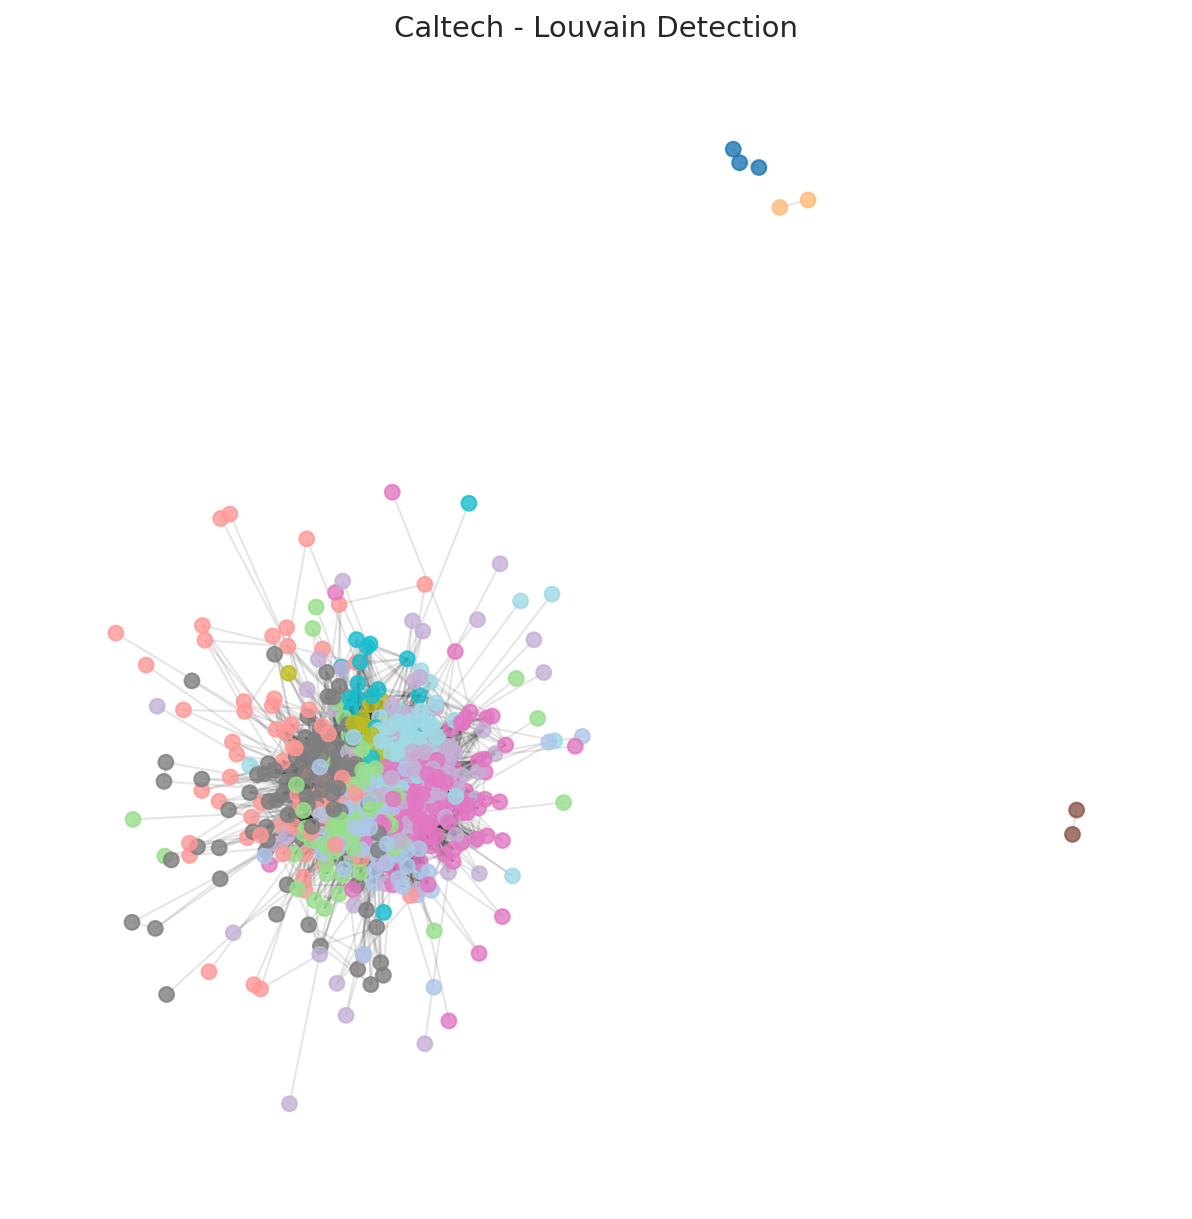

In [ ]:
def visualize_communities(G, partition_sets, title="Community Structure"):
    """
    Visualizes the graph with nodes colored by their community.
    Args:
        G: NetworkX graph
        partition_sets: List of sets of nodes (output from louvain_communities)
    """
    # Create a map: node_id -> community_id
    node_to_community = {}
    for idx, comm in enumerate(partition_sets):
        for node in comm:
            node_to_community[node] = idx

    # Get colors
    node_colors = [node_to_community.get(n, 0) for n in G.nodes()]

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42, k=0.15) # k regulates spacing

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab20,
                           node_size=50, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.1)

    plt.title(title)
    plt.axis('off')
    plt.show()

visualize_communities(graphs['Caltech'], community_results['Caltech']['Louvain'], "Caltech - Louvain Detection")